In [174]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report,confusion_matrix

rcParams['font.family']  = 'Times New Roman'


## 模型实现

In [175]:

# 转换成叶子结点特征
def transform_to_leaf_features(gbdt, X):
    """
    gbdt: GBDT model
    X: input data
    return: leaf features
    """

    #获取样本落入每一颗树的叶子结点的索引
    leaf_indices  = gbdt.apply(X) #X_leaves : array-like of shape (n_samples, n_estimators, n_classes)
    leaf_indices = leaf_indices.reshape(X.shape[0],-1)

    leaf_indices = leaf_indices.astype(int)

    #对树叶子结点进行one-hot编码
    #可以用sklearn内置的OneHotEncoder().fit_transform(res).toarray(),但这里为了学习,还是采用手撕方式
    n_estimators = leaf_indices.shape[1]
    n_leaves = int(np.max(leaf_indices)) + 1 #每一个ont-encode的列数
    transformed_matrix = np.zeros((X.shape[0], n_estimators * n_leaves),dtype= int)

    for i in range(n_estimators):
        for j in range(X.shape[0]):
            transformed_matrix[j, i * n_leaves + leaf_indices[j,i] ] = 1

    return transformed_matrix


In [176]:
#数据预处理
X,y = make_classification(
    n_samples = 1000,
    n_features = 20,
    n_informative = 15, #指定其中有多少个特征是“信息性”的（即对分类目标有帮助的）
    n_redundant = 5, #指定有多少个特征是“冗余”的。冗余特征是通过将信息性特征进行线性组合生成的
    random_state = 42 
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [177]:
# 训练GBDT模型
gbdt = GradientBoostingClassifier(
    n_estimators = 100, # 使用100个决策树
    max_depth = 4, # 树的最大深度为4
    learning_rate = 0.1,
    random_state = 42
)

gbdt.fit(X_train, y_train)

# 利用GBDT生成新的特征
X_train_transformed = transform_to_leaf_features(gbdt, X_train)
X_test_transformed = transform_to_leaf_features(gbdt, X_test)

# 训练LR模型
lr = LogisticRegression(max_iter = 1000, random_state = 42)
lr.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 模型评估

In [178]:
y_pred =  lr.predict(X_test_transformed)
res = classification_report(y_test,y_pred)
print(res)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       160
           1       0.89      0.94      0.91       140

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



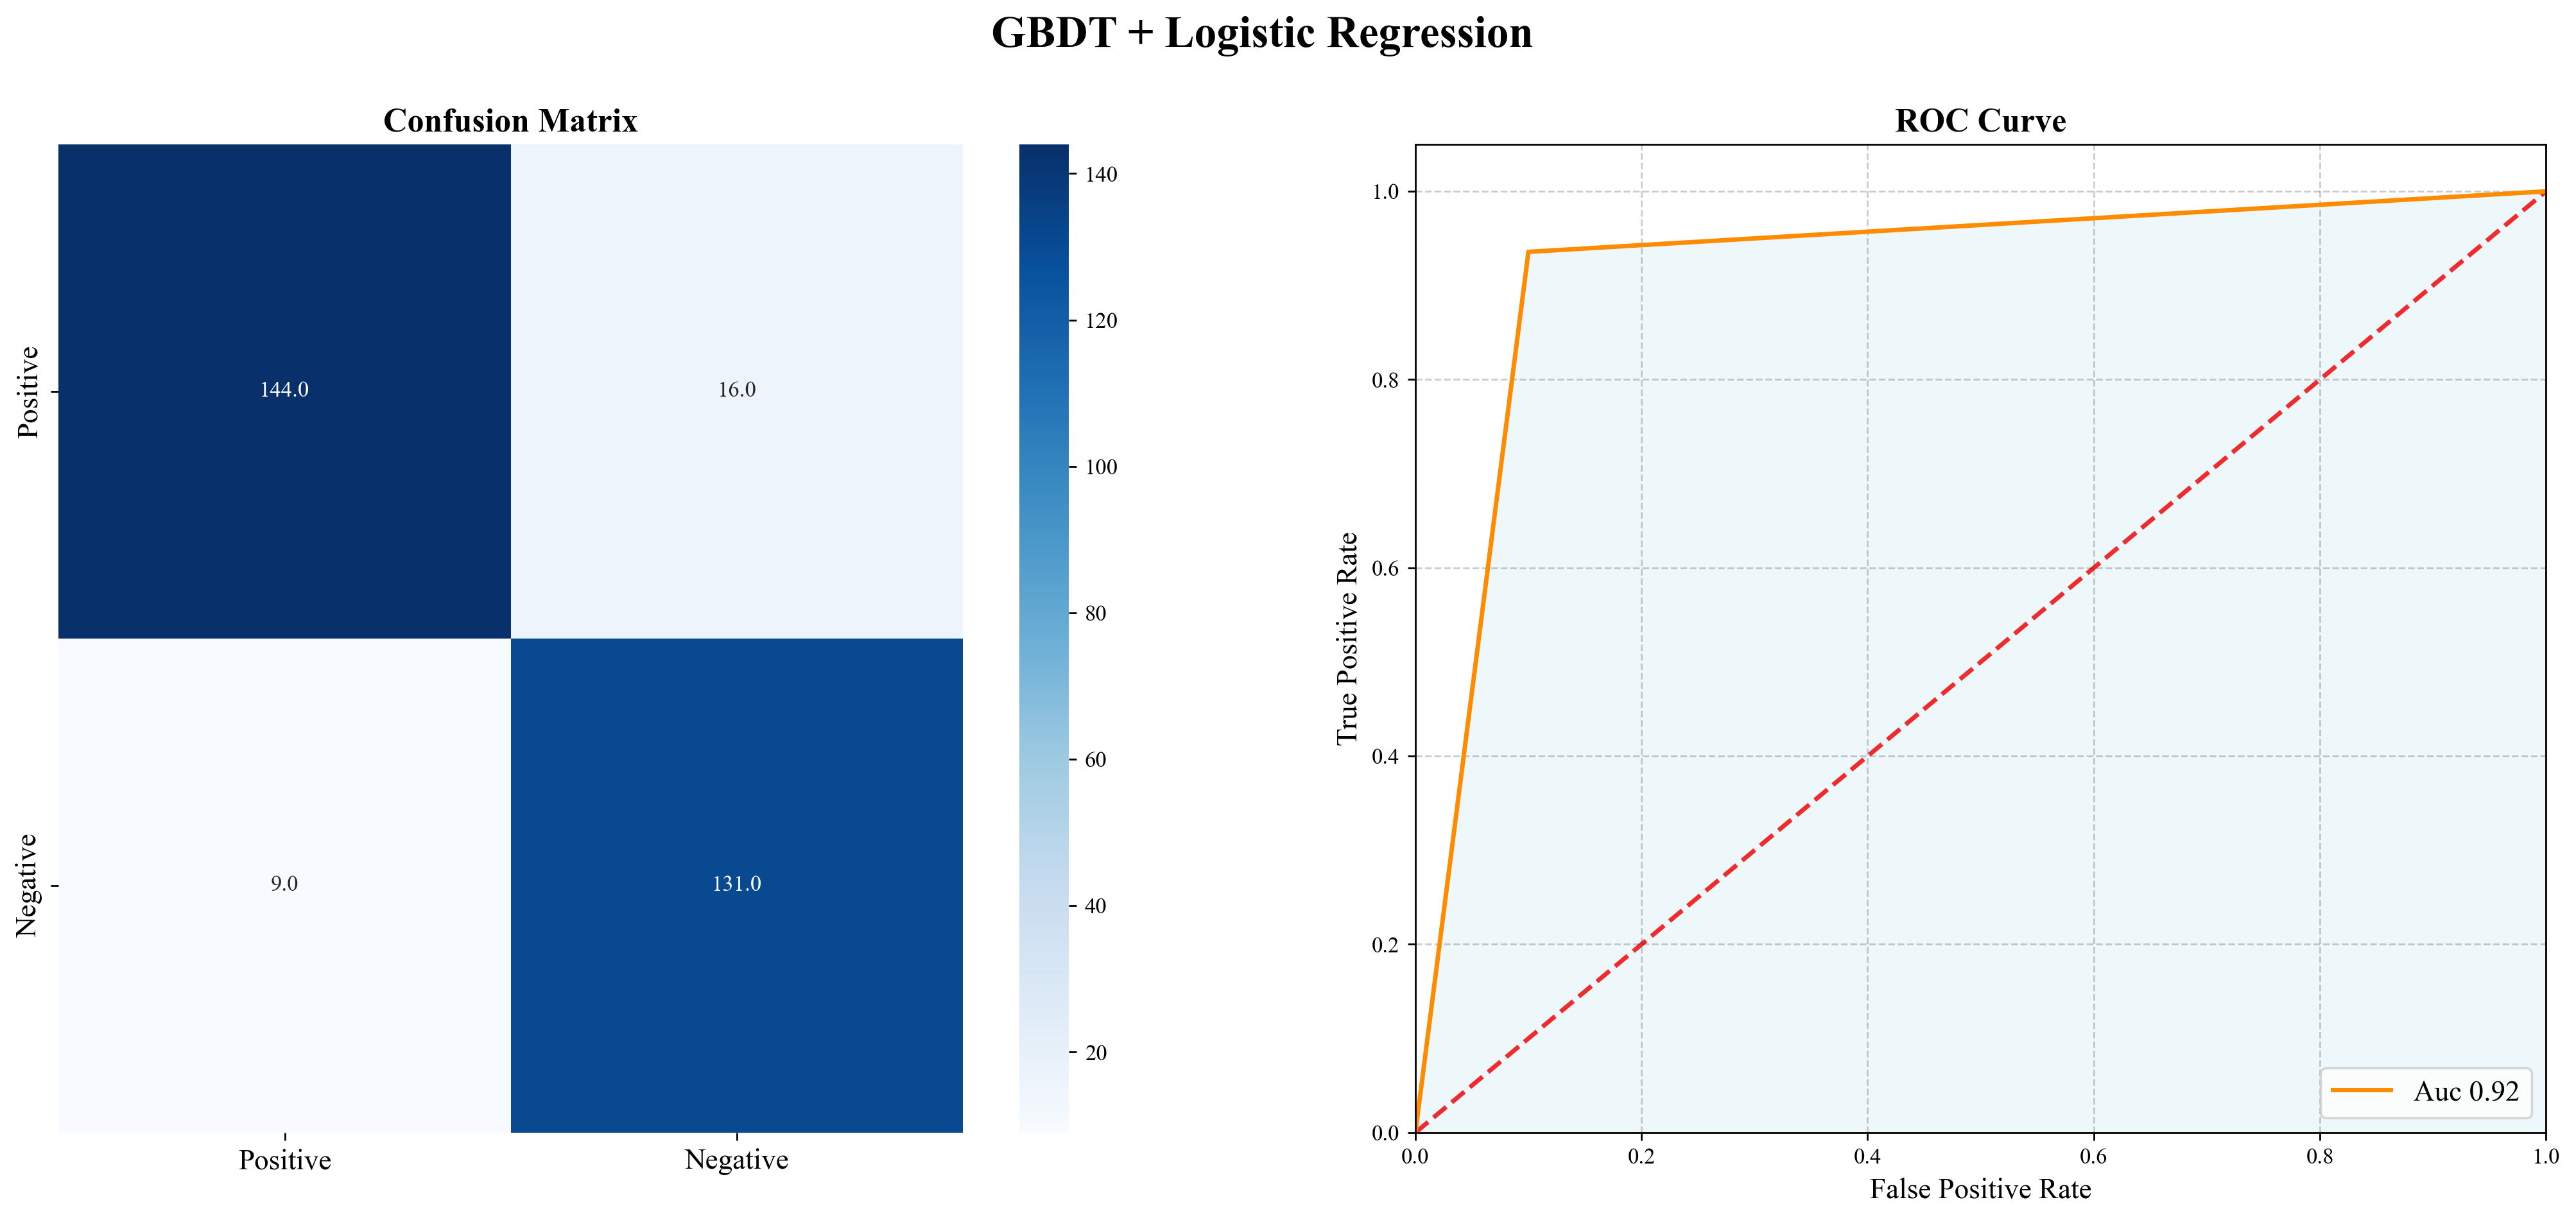

In [196]:
con_matrix = confusion_matrix(y_test, y_pred)

# 计算AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

fig, axes = plt.subplots(1,2,figsize=(20, 8),dpi = 250)
axes = axes.flatten()

# 绘制混淆矩阵
plt.suptitle('GBDT + Logistic Regression',fontsize = 20, fontweight = 'bold')
axes[0].set_title('Confusion Matrix',fontsize = 15, fontweight = 'bold')
sns.heatmap(con_matrix, annot = True, fmt = '.1f', cmap = 'Blues',ax = axes[0])
axes[0].set_xticks([0.5, 1.5], ['Positive','Negative'],fontsize = 13)
axes[0].set_yticks([0.5, 1.5], ['Positive','Negative'],fontsize = 13)


axes[1].set_title('ROC Curve',fontsize = 15, fontweight = 'bold')

axes[1].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Auc %.2f' % roc_auc,zorder = 2)
axes[1].grid(alpha = 0.2,color = 'black', linestyle = '--',zorder = 1)
axes[1].plot([0,1],[0,1],color = 'red',lw = 2, linestyle = '--',zorder = 1)
axes[1].legend(loc = 4, fontsize = 13)
axes[1].fill_between(fpr, tpr, color = 'lightblue', alpha = 0.2)
axes[1].set_xlabel('False Positive Rate',fontsize = 13)
axes[1].set_ylabel('True Positive Rate',fontsize = 13)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

# 绘制ROC曲线
plt.show()

综合来看 GBDT + LR的模型还不错,但GBDT容易过拟合，以及GBDT的特征转换方式实际上丢失了大量特征信息的数据信息，**因此不能简单的数据说GBDT的特征交叉能力强，效果比其他模型好**，在模型的选择和调试上，永远都是多种因素综合作用的结果